This notebook is a from-scratch implementation of the "Intriguing properties of neural networks" research paper published by Szegedy et al. (2014). It was the first paper to show this phenomenon: by only slightly modifying an image, it is
possible to drastically change the predictions of the network.

In [1]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.autograd import grad

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

We will use the Squeezenet model which is a light model pre-trained on ImageNet. Why a light model? because we will need to calculate a lot of gradients and I don't have enough resources and time for that 🙂

In [2]:
model = torchvision.models.squeezenet1_1(pretrained=True)
model.eval()
for param in model.parameters():
    param.requires_grad = False

We load 25 examples from ImageNet for our experimentations. 

In [3]:
!wget https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky -O images.npz

--2022-03-13 22:36:20--  https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky
Resolving drive.google.com (drive.google.com)... 142.250.148.101, 142.250.148.102, 142.250.148.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.148.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/ [following]
--2022-03-13 22:36:20--  https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/edit [following]
--2022-03-13 22:36:20--  https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/edit
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘images.npz’

images.npz      

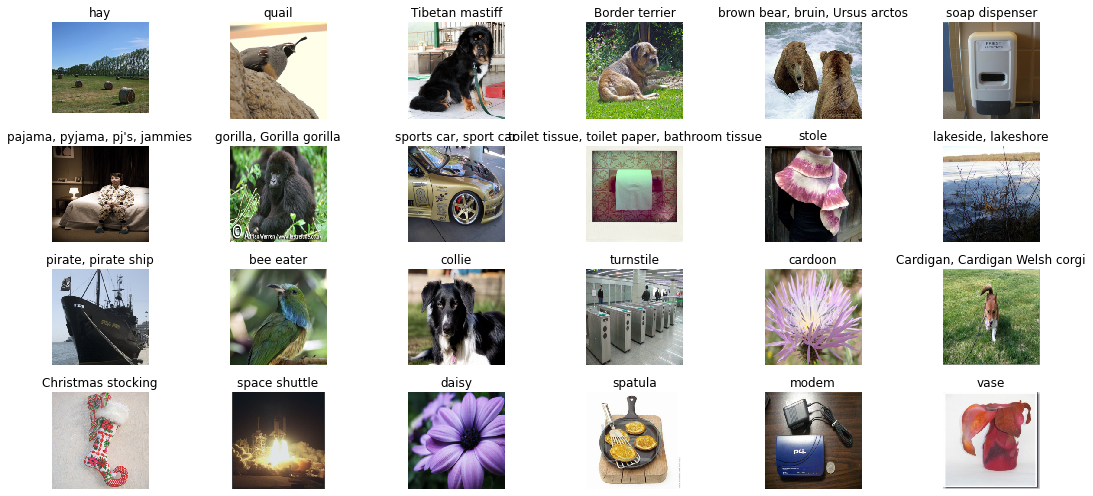

In [6]:
f = np.load("images.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [7]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Scale(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [8]:
# Initialize tests
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[0])))
target_y = class_names_to_id['stingray']  # Desired class
X_fooling = X_tensor.clone()
X_fooling.requires_grad = True
learning_rate = 1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Calculating an image such that it will be classified in a target_y different from the real class by modifying the image and not the network parameters.

In [9]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, enable gradients.
    X_fooling = X.clone()
    X_fooling.requires_grad = True
    
    learning_rate = 1
    ind=True
    while(ind):
      out=model(X_fooling)
      predicted=torch.argmax(out)
      if predicted.item()==target_y:
        ind=False
      else :
        g=grad(out[0][target_y],X_fooling,retain_graph=True)[0]
        X_fooling=X_fooling+learning_rate*(g/(torch.norm(g)))
    return X_fooling

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


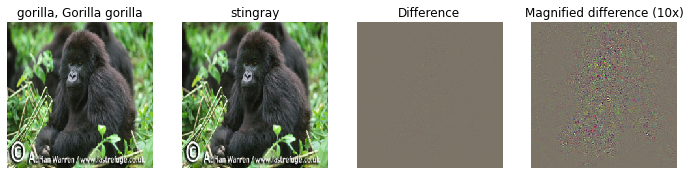

In [10]:
# Index of the image to modify and the target class
idx = 7
target_y = class_names_to_id['stingray']

# Preparation of tensor X and it's "fooling" version
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

# Check the predicted class
scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0], 'The model is not fooled!'

# Display
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()